In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import operator
import pickle
import random
from collections import Counter

from rdkit import Chem
from rdkit.Chem import Draw

from demo import (extract_all, load_retrieved_candidates,
                  load_sub_seq2seq_output, merge,
                  merge_predicted_frag_with_substructures,
                  prepaire_sub_seq2seq_input, rerank_candidates,
                  save_input_for_dual_encoder, save_input_for_subseq2seq,
                  view_sub_extractions)
from utils.smiles_utils import smi_tokenizer


In [3]:
# this file is a dictionary, key: target (reactants), value: source (all possible products)
# it is generated on the train and val data by 'data_utils/collect_reaction.py', and is used
# to filter substructures extracted from candidate reactants (target side) but not exists in
# the product molecules (source side). It means that the substructures shall also remain
# unchanged during the reaction from source (product of retrieved candidate reactants) to 
# target (retrieved candidate reactants). 
# load only for the first time
try:
    all_reaction_t2s
except NameError:
    all_reaction_t2s = pickle.load(open('demo_data/reaction.pkl', 'rb'))

input_product_smiles: CC1=C(C(=O)NCCCN2CCC(c3cccc(NC(=O)C(C)C)c3)CC2)C(c2ccc(F)cc2F)CC(=O)N1
golden_reactants_smiles: CC(C)C(=O)Nc1cccc(C2CCN(CCCN)CC2)c1.CC1=C(C(=O)O)C(c2ccc(F)cc2F)CC(=O)N1


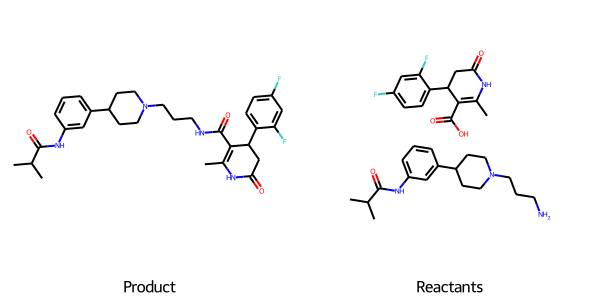

In [4]:

# we prepaire 200 samples in demo_data/test_cases.json, in which 's' is the source (product) and 't' is the target (reactant)
test_cases = json.load(open('demo_data/test_cases.json'))
# some typical cases in test_cases.json, change the value of test_case_idx below to view results
#   1 Suzuki-Miyaura Cross Coupling
#   2 Amide Condensation
#   5 SN2 Substitution
#   6 Ester Hydrolysis(Deprotection)
#  16 Sonogashira Cross Coupling
#  19 Nitro Reduction
#  22 Free Radical Halogenation
#  43 Nitrile Hydrolysis
#  56 Aldol Condensation
# 145 Sulphur Oxidation

# please change test_case_idx, or change the input below, to try other examples
test_case_idx = 2

input_product_smiles, golden_reactants_smiles = test_cases[test_case_idx]['s'], test_cases[test_case_idx]['t']
print(f'input_product_smiles: {input_product_smiles}')
print(f'golden_reactants_smiles: {golden_reactants_smiles}')
Draw.MolsToGridImage([Chem.MolFromSmiles(input_product_smiles), Chem.MolFromSmiles(golden_reactants_smiles)], \
    legends=['Product', 'Reactants'],
    molsPerRow=2, subImgSize=(300, 300))

In [5]:
# the input of the dual encoder is tokenized SMILES of product
tokenized_product_smi = smi_tokenizer(input_product_smiles)
# save the input to file
save_input_for_dual_encoder(tokenized_product_smi)
print('tokenized_product_smi: ', tokenized_product_smi)

tokenized_product_smi:  C C 1 = C ( C ( = O ) N C C C N 2 C C C ( c 3 c c c c ( N C ( = O ) C ( C ) C ) c 3 ) C C 2 ) C ( c 2 c c c ( F ) c c 2 F ) C C ( = O ) N 1


In [6]:
# view the script to retrieve reactions top 20 candidates
# the input file is 'test_input_dual_encoder.txt'
# the output file is 'test_input_dual_encoder.top20.txt'
! cat demo_data/retrieval_script.sh

#!/bin/bash

# current directory
CURRENT_DIR=$PWD
# script directory
SCRIPT_DIR=$(cd "$(dirname "${BASH_SOURCE[0]}")" &> /dev/null && pwd)
# change to script directory
cd $SCRIPT_DIR
# retrieve top 20 candidates
top=20
# run the retrieval script
python3 -u ../RetrievalModel/search_index.py \
        --input_file test_input_dual_encoder.txt \
        --output_file test_input_dual_encoder.top${top}.txt \
        --ckpt_path retrieval/query_encoder \
        --args_path retrieval/args \
        --vocab_path retrieval/src.vocab \
        --index_file candidates.txt \
        --index_path retrieval/mips_index \
        --topk ${top} \
        --allow_hit \
        --batch_size 1024
# change back to current directory
cd $CURRENT_DIR

In [7]:
# run script to retrieve candidates
! conda run -n retrieval bash demo_data/retrieval_script.sh 

09/13/2022 02:17:10 - INFO - __main__ - Loading model...
09/13/2022 02:17:12 - INFO - __main__ - Collecting data...
09/13/2022 02:17:12 - INFO - __main__ - Collected 1 instances
09/13/2022 02:17:13 - INFO - __main__ - Start search
09/13/2022 02:17:13 - INFO - __main__ - finished 1 / 1



In [8]:
# view output of dual encoder (all content in 1 line)
# tokenized_product_SMILES \TAB TGT_PLACEHOLDER \TAB retrieved_candidate_SMILES_1 \SPACE score_1 \SPACE retrieved_candidate_SMILES_2 \SPACE score_2	...
# \TAB => \t , \SPACE=> space, TGT_PLACEHOLDER is a placeholder which is not used
! cat demo_data/test_input_dual_encoder.top20.txt

C C 1 = C ( C ( = O ) N C C C N 2 C C C ( c 3 c c c c ( N C ( = O ) C ( C ) C ) c 3 ) C C 2 ) C ( c 2 c c c ( F ) c c 2 F ) C C ( = O ) N 1	TGT_PLACEHOLDER	C C C ( C C ) C ( = O ) N c 1 c c c ( N 2 C C N ( C ( C ( = O ) O ) c 3 c c c c ( F ) c 3 ) C C 2 ) c ( F ) c 1 . C C C ( C C ) C ( = O ) N c 1 c c c ( N 2 C C N ( C ( C ( = O ) O C ) c 3 c c c c ( F ) c 3 ) C C 2 ) c ( F ) c 1	0.9493697881698608	C C ( C ) C ( = O ) N c 1 c c c ( F ) c ( C 2 C C N ( C C C N ) C C 2 ) c 1 . O = C ( O ) C 1 ( c 2 c c c ( F ) c c 2 ) C C C C C 1	0.9484293460845947	C C ( C ) C ( = O ) N c 1 c c c ( F ) c ( C 2 C C N ( C C C N ) C C 2 ) c 1 . O = C ( O ) C 1 ( c 2 c c c ( F ) c c 2 ) C C C C 1	0.9483911991119385	C C ( C ) C ( = O ) N c 1 c c c c ( C 2 C C N ( C C C N ) C C 2 ) c 1 . Cl C Cl . O = C ( [O-] ) [O-] . O = C 1 O C [C@@H] ( c 2 c c c ( F ) c ( F ) c 2 ) N 1 C ( = O ) O c 1 c c c ( [N+] ( = O ) [O-] ) c c 1	0.9481363296508789	C C ( C ) C ( = O ) N c 1 c c ( C 2 C C N ( C C C N ) C C 2 ) c ( F )

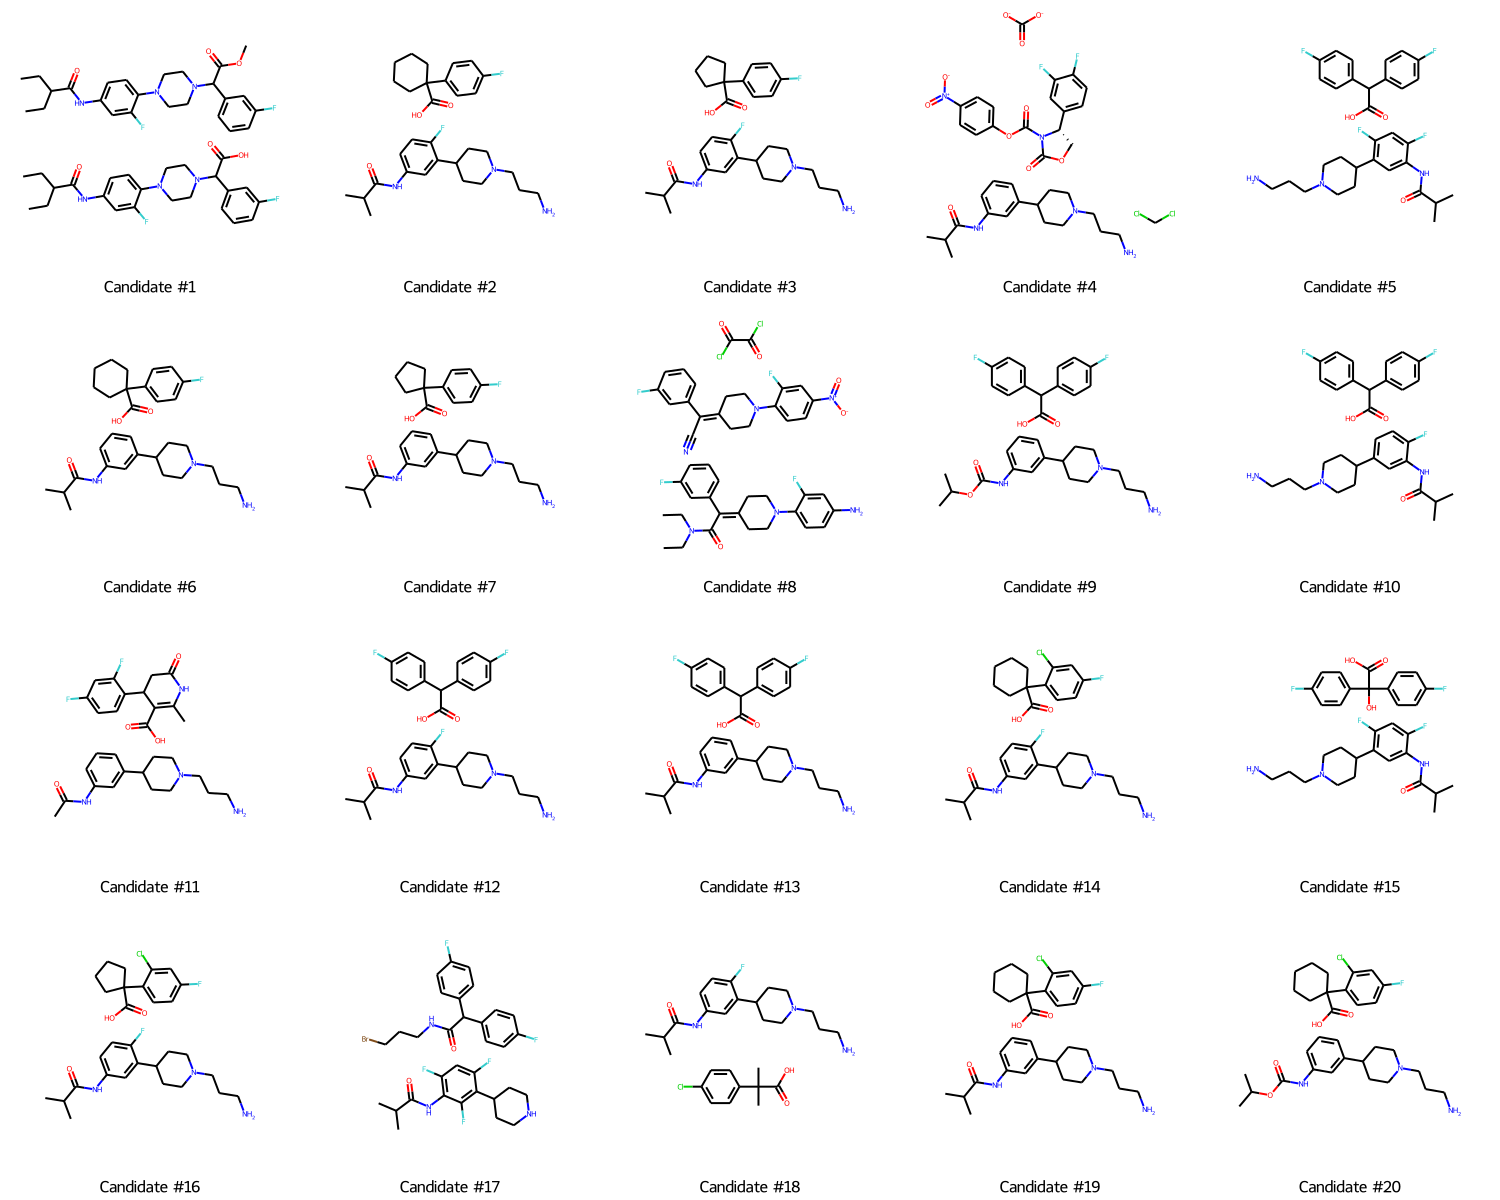

In [9]:
# the total number of candidates might be 19, as we remove the input_product_smiles from retrieved candidates if exists
candidates = load_retrieved_candidates(input_product_smiles)
Draw.MolsToGridImage([Chem.MolFromSmiles(cand) for cand in candidates], molsPerRow=5, subImgSize=(300, 300), legends= [f'Candidate #{i+1}' for i in range(len(candidates))])

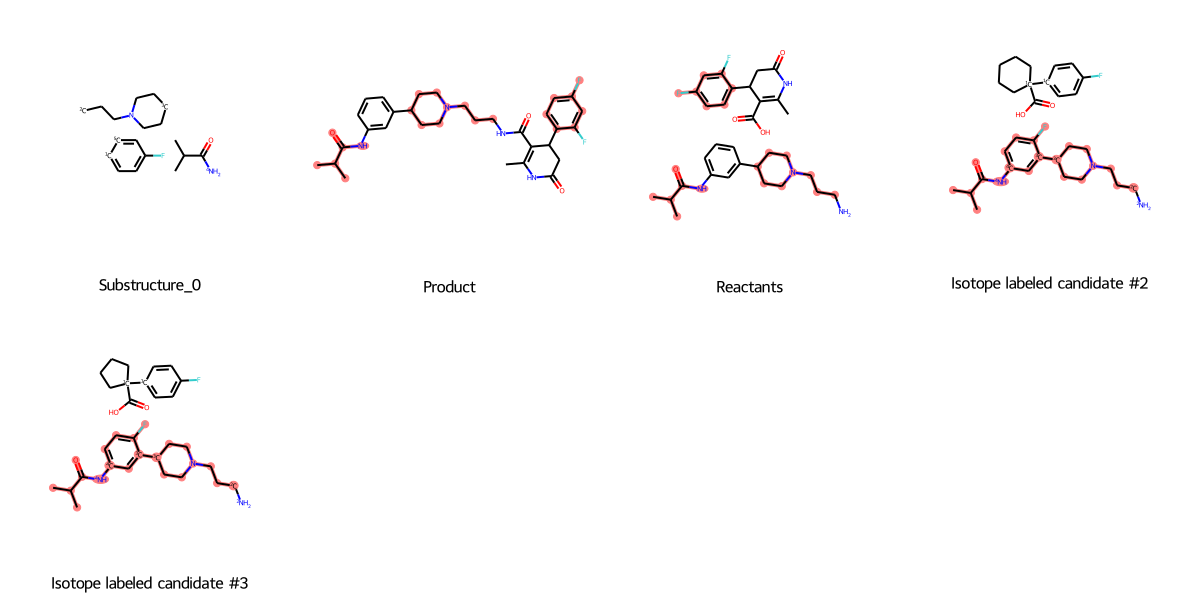

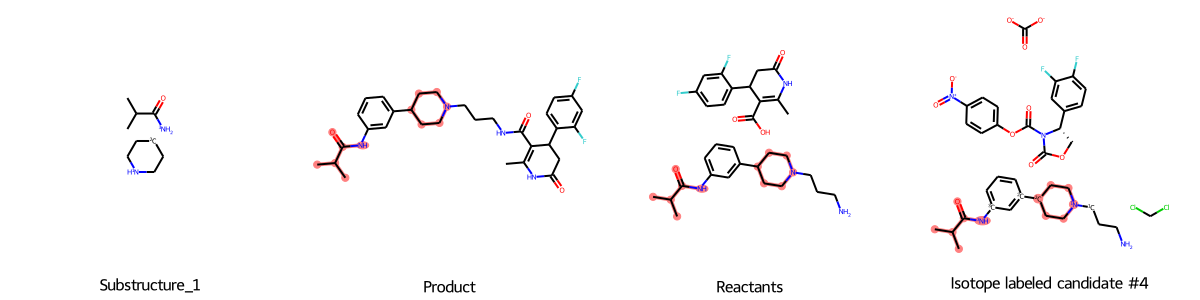

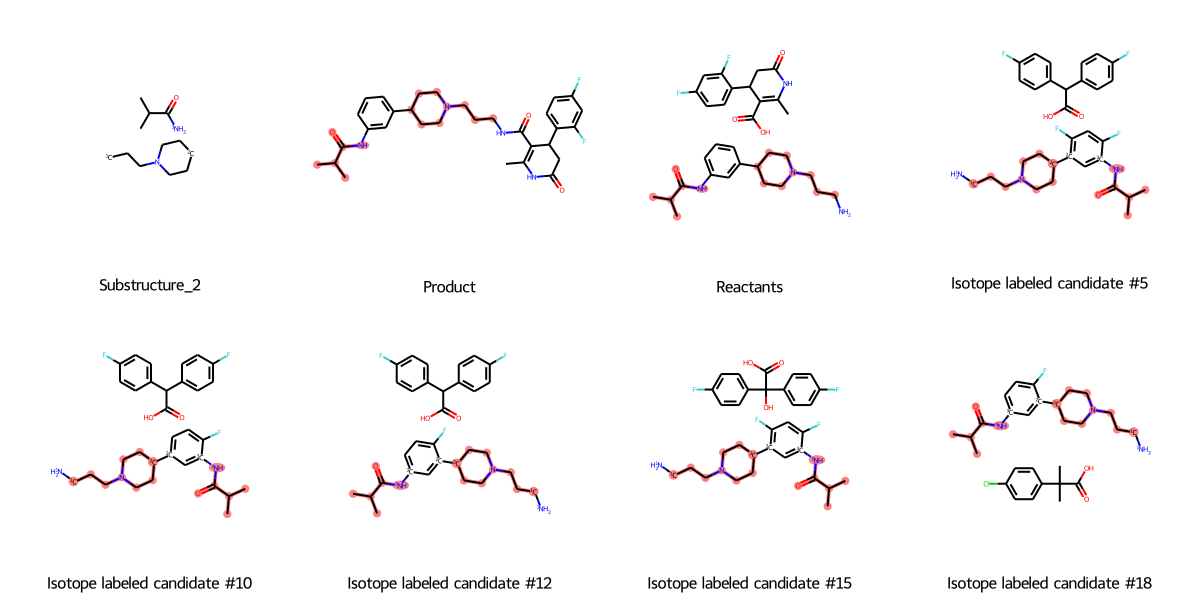

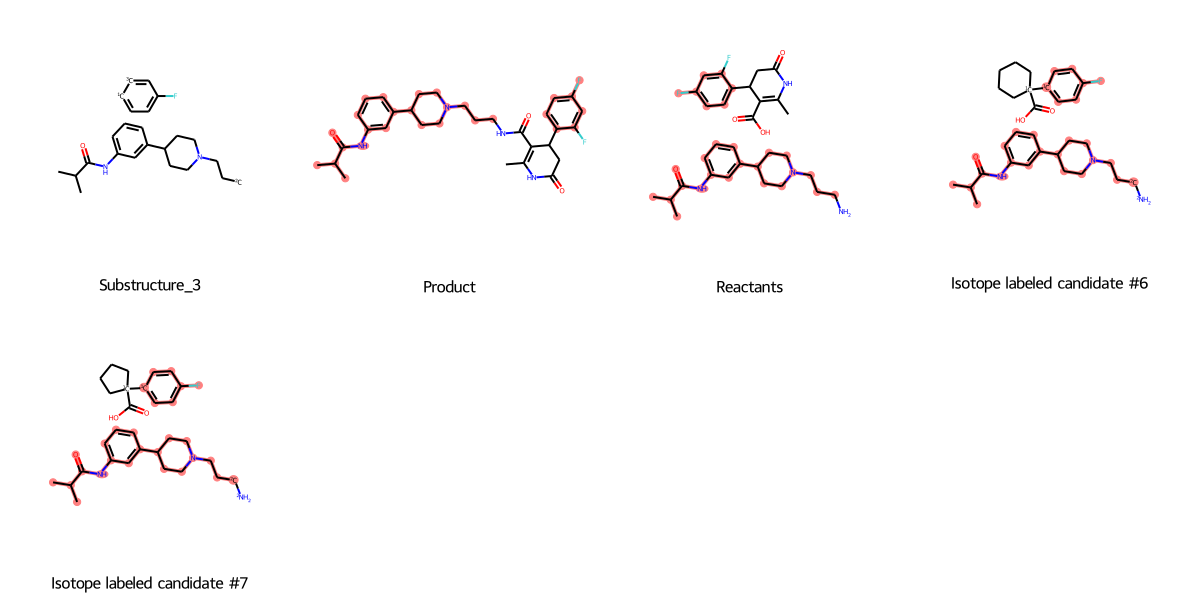

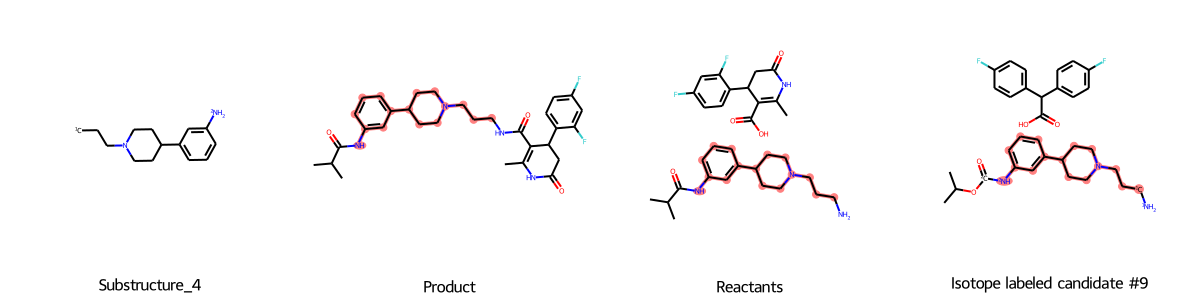

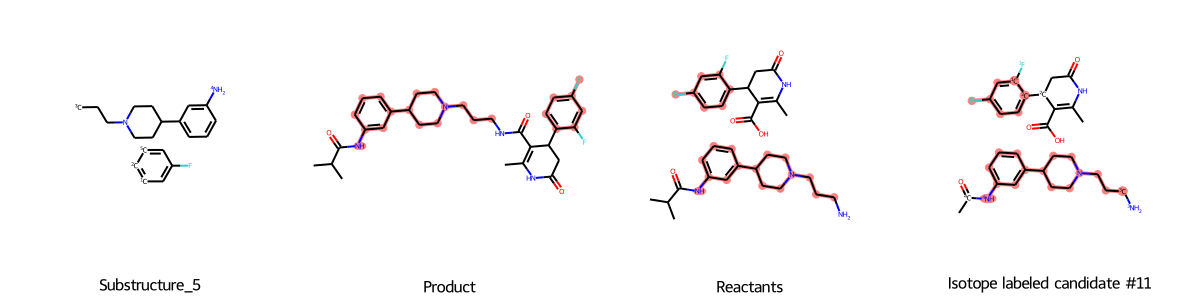

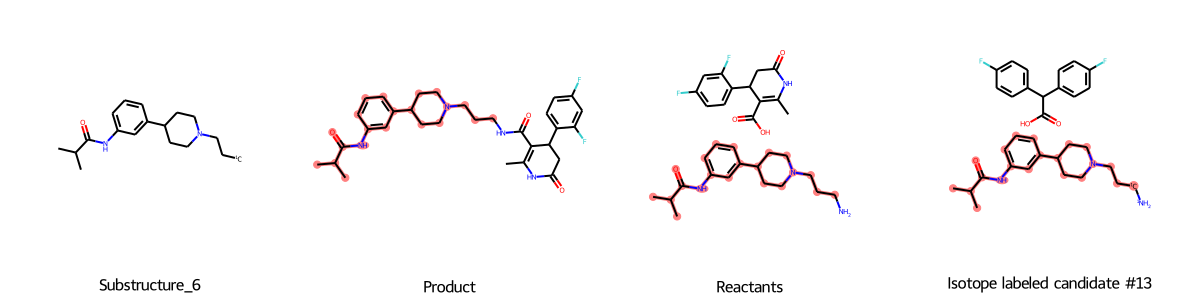

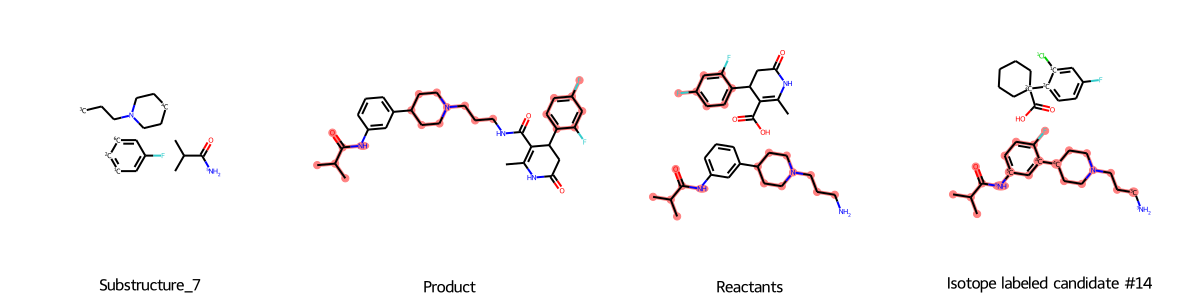

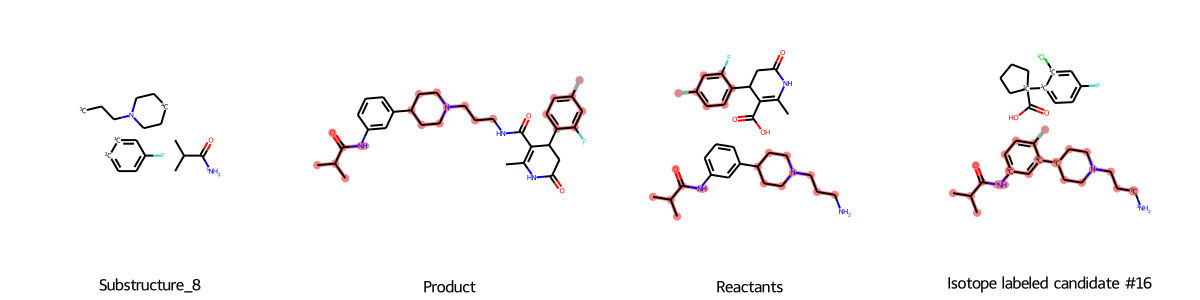

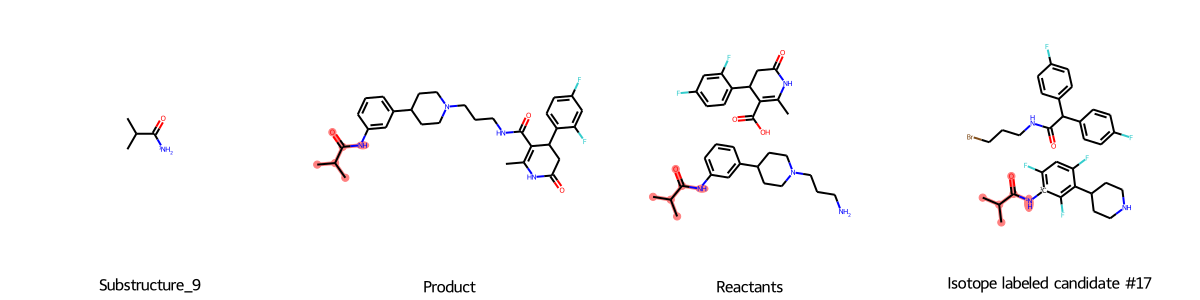

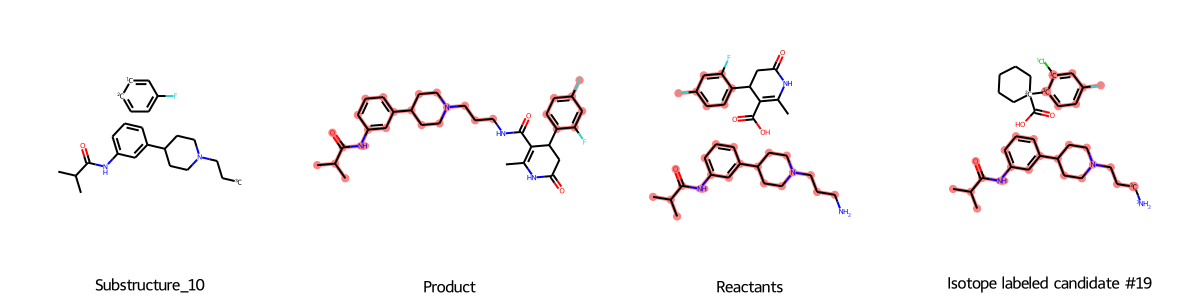

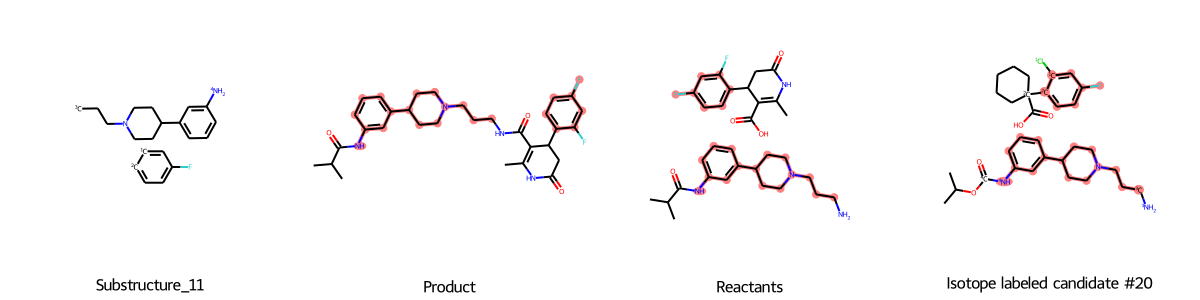

In [10]:
# do substructure extraction from all retrieved candidates
extraction_results = extract_all(input_product_smiles, candidates, all_reaction_t2s, min_count=5)

# view extraction results
# NOTE1: some isotope numbers in substructure are not shown in the labeled candidate reactants,
# because the product molecules of those candidates have none-substrcucture neighbour atoms, 
# which are not shown here.
# NOTE2: some substructures differ only in the isotope numbers, we consider them as different
# substructures.
view_sub_extractions(input_product_smiles, golden_reactants_smiles, candidates, extraction_results)
   

In [11]:
# prepare input for substructure-level sequence to sequence model inference
# subs_for_merge will be used to merge substructure with fragments
input_smiles, subs_for_merge = prepaire_sub_seq2seq_input(extraction_results)

# save the input 
save_input_for_subseq2seq(input_smiles)

# view random 5 samples
print('\n'.join(random.sample(input_smiles, 5)))

C C ( C ) C ( [4NH2] ) = O . F c 1 c c [1cH] [5cH] c 1 . [2CH3] C C N 1 C C [3CH2] C C 1 | C C 1 = C ( C ( [2NH2] ) = O ) [1CH2] C C ( = O ) N 1 . [5FH] . c 1 c [3cH] c [4cH] c 1
C ( [1CH3] ) C N 1 C C [2CH2] C C 1 . C C ( C ) C ( [3NH2] ) = O | c 1 c c ( c ( c c 1 F ) F ) C 1 C C ( = O ) N C ( C ) = C 1 C ( [1NH2] ) = O . [3cH] 1 c c c [2cH] c 1
C ( N 1 C C C ( c 2 c c ( c c c 2 ) N C ( = O ) C ( C ) C ) C C 1 ) C [1CH3] | C C 1 = C ( C ( C C ( N 1 ) = O ) c 1 c ( c c ( c c 1 ) F ) F ) C ( = O ) [1NH2]
C C ( C ) C ( [3NH2] ) = O . C 1 C [1NH] C C [2CH2] 1 | F c 1 c c ( F ) c c c 1 C 1 C C ( N C ( C ) = C 1 C ( N C C [1CH3] ) = O ) = O . [2cH] 1 c [3cH] c c c 1
[4NH2] c 1 c c c c ( c 1 ) C 1 C C N ( C C 1 ) C C [3CH3] . c 1 [5cH] [2cH] [1cH] c c 1 F | C C ( [4CH] = O ) C . [5FH] . [3NH2] C ( C 1 = C ( N C ( C [2CH2] 1 ) = O ) C ) = O


In [12]:
# view the script for inference
# Note: n_best is set to 10
! cat demo_data/subseq2seq.sh

print('\n\n\n############### Run Inference ###############\n\n\n')

! bash demo_data/subseq2seq.sh

#!/bin/bash

# current directory
CURRENT_DIR=$PWD
# script directory
SCRIPT_DIR=$(cd "$(dirname "${BASH_SOURCE[0]}")" &> /dev/null && pwd)
# change to script directory
cd $SCRIPT_DIR
# uncomment -gpu 1 if you have GPUs
python ../MolecularTransformer/translate.py \
            -model subseq2seq.pt \
            -src test_input_seq2seq.txt \
            -output predict_output.txt \
            -batch_size 10 -replace_unk -max_length 200 -fast -n_best 10 -beam_size 10  -gpu 1
cd $CURRENT_DIR


############### Run Inference ###############



PRED AVG SCORE: -0.0015, PRED PPL: 1.0015


In [13]:
# load model output, a list of tuple (rank, predicted_fragments)
rank_pred_frag_list = load_sub_seq2seq_output()
rank_pred_frag_list[:5]

[(0, 'CC1=C(C(=O)O)[1CH2]CC(=O)N1.[2NH3].[5FH].c1c[3cH]c[4cH]c1'),
 (1, 'CC1=C(C(=O)[O-])[1CH2]CC(=O)N1.[2NH3].[5FH].c1c[3cH]c[4cH]c1'),
 (2, 'CC1=C(C(=O)O)[1CH2]CC(=O)N1.[2NH3].[5CH4].c1c[3cH]c[4cH]c1'),
 (3, 'CC1=C(C(=O)O)[1CH2]CC(=O)N1.[2NH3].[5FH].c1c[2cH]c[4cH]c1'),
 (4,
  'CC1=C(C(=O)O)[1CH2]CC(=O)N1.[2NH2]C(=O)OCc1ccccc1.[5FH].c1c[3cH]c[4cH]c1')]

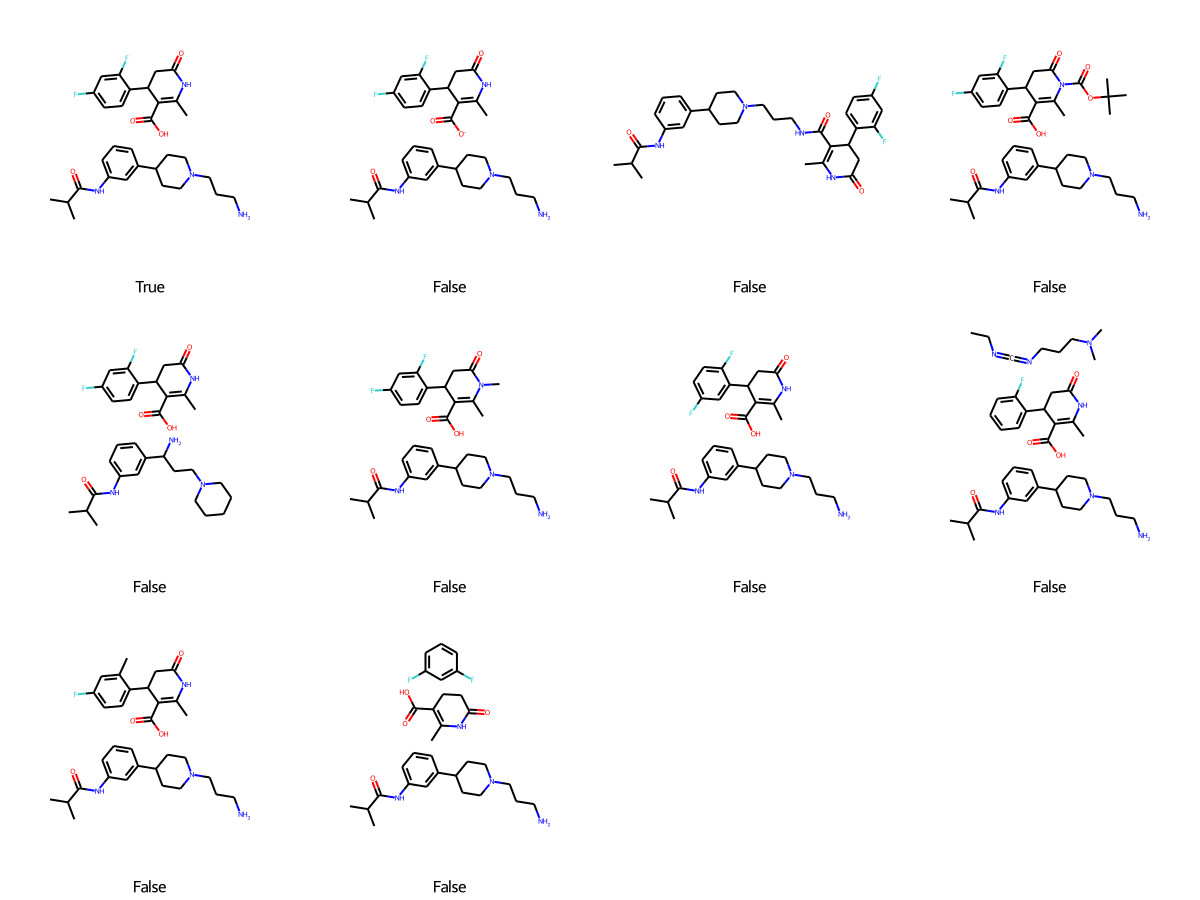

In [14]:
# merge predicted fragments with substructures
# predict2sub_rank is a dictionary
#       key: SMILES of merged reactants
#       value: a list of tuple (SMILES of substructure, PLACEHOLDER, rank) 
# we will extract features from value for reranking. 
# all_predictions is a list of tuple (SMILES of merged reactants, flag) and flag = [True, False]
# there might have duplicate entries in all_predictions, because different substructures might have same prediction.
pred2sub_rank, all_predictions = merge_predicted_frag_with_substructures(rank_pred_frag_list, subs_for_merge, golden_reactants_smiles)

# view most frequent entries in all_predictions
predicted_smi2label_list = [ele[0] for ele in Counter(all_predictions).most_common(10)]
Draw.MolsToGridImage([Chem.MolFromSmiles(ele[0]) for ele in predicted_smi2label_list], legends=[str(ele[1]) for ele in predicted_smi2label_list], molsPerRow=4, subImgSize=(300, 300))

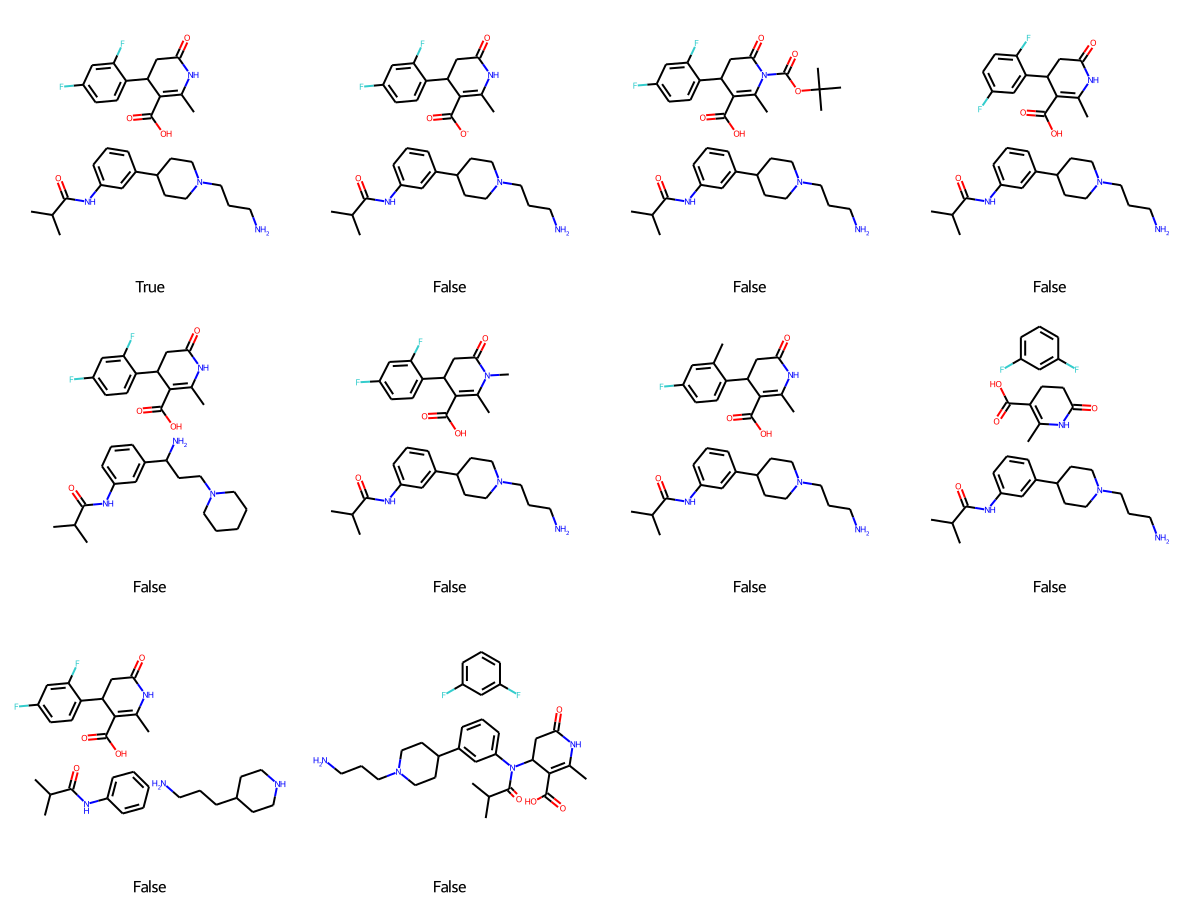

In [15]:
# rerank
pred_smi2score = rerank_candidates(input_product_smiles, pred2sub_rank, all_predictions)
d = sorted(pred_smi2score.items(), key=operator.itemgetter(1),reverse=True)
reranked_predicted_smi2label_list = [ele[0] for ele in d[:10]]
Draw.MolsToGridImage([Chem.MolFromSmiles(ele[0]) for ele in reranked_predicted_smi2label_list], legends=[str(ele[1]) for ele in reranked_predicted_smi2label_list], molsPerRow=4, subImgSize=(300, 300))